## Importing Required Libraries

In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dropout, Flatten, Dense
from tensorflow.keras.layers import Conv2D, MaxPooling2D,GlobalAveragePooling2D, BatchNormalization
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, roc_curve, auc
from tensorflow.keras.metrics import TruePositives, FalsePositives, TrueNegatives, FalseNegatives, BinaryAccuracy, Precision, Recall, AUC
from tensorflow.keras.metrics import SpecificityAtSensitivity
from sklearn.preprocessing import label_binarize
import tensorflow.keras as keras
from tensorflow.keras import regularizers
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import cv2
import os
import random
import matplotlib as mpl
import seaborn as sns
import shutil
import math
from IPython.core.display import HTML,display
import matplotlib.image as mpimg
import tensorflow.keras as keras
from tensorflow.keras import regularizers
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.initializers import GlorotNormal
from tensorflow.keras import backend as K
from tensorflow.keras.utils import get_file
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet import ResNet101
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras import Model, layers
from tensorflow.keras.models import load_model, model_from_json
import time
from tensorflow.keras.applications.efficientnet import EfficientNetB4
from skimage.metrics import peak_signal_noise_ratio

import warnings as ws
ws.filterwarnings("ignore")
np.random.seed(42)
tf.random.set_seed(42)
random.seed(42)
pd.set_option('max_colwidth', 800)
from tensorflow.keras.callbacks import EarlyStopping, TensorBoard

/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: libtensorflow_io.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so: undefined symbol: _ZTVN10tenso

## Extracting Files

In [2]:
c = '/kaggle/input/datacxr2/Data CXR-2/dataset/1_Covid19'
n = '/kaggle/input/datacxr2/Data CXR-2/dataset/0_Normal'
p = '/kaggle/input/datacxr2/Data CXR-2/dataset/2_Pneumonia'

In [3]:
%%time
random.seed(42)
image_name=[]
categories = []
for index,filenames in enumerate ([n,p,c]):
    for filename in os.listdir(filenames):
        image_name.append(os.path.join(filenames,filename))
        categories.append(str(index))

CPU times: user 28 ms, sys: 12.9 ms, total: 40.8 ms
Wall time: 321 ms


### Classes
* 0 -> Normal
* 1 -> Viral Pneumonia
* 2 -> COVID

## Converting to Dataframe

In [4]:
df = pd.DataFrame({
    'filename': image_name,
    'category': categories
})

In [5]:
df.category.value_counts()

1    4657
2    3483
0    3270
Name: category, dtype: int64

In [6]:
df.head()

,filename,category
0,/kaggle/input/datacxr2/Data CXR-2/dataset/0_Normal/Normal (2814).jpg,0
1,/kaggle/input/datacxr2/Data CXR-2/dataset/0_Normal/Normal (1525).jpg,0
2,/kaggle/input/datacxr2/Data CXR-2/dataset/0_Normal/Normal (1926).jpg,0
3,/kaggle/input/datacxr2/Data CXR-2/dataset/0_Normal/Normal (398).jpg,0
4,/kaggle/input/datacxr2/Data CXR-2/dataset/0_Normal/Normal (1239).jpg,0


## Exploratory Data Analysis

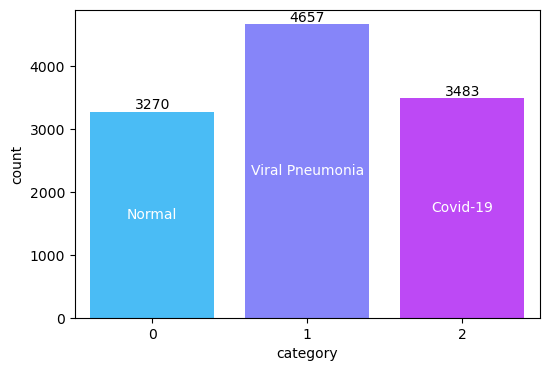

In [7]:
def DistData(data,name):
    display(HTML('<H5 style="color:blue"> <b>Sebaran {} Data </b></H5><hr>'.format(name)))
    plt.figure(figsize=(6, 4))
    ax = sns.countplot(data = data.sort_values(by='category'), x ='category', palette='cool',
                       saturation=0.9)
    for container in ax.containers:
        ax.bar_label(container)
    ax.bar_label(container=ax.containers[0], labels=['Normal','Viral Pneumonia', 'Covid-19'], 
                  label_type='center', size=10, color='w')
    plt.show()
    
    
DistData(df, '')

## Data Visualization

## Splitting Train, Validation & Test Data

In [8]:
train_data, test_valid_data = train_test_split(df, test_size=0.3, random_state = 42, shuffle=True, stratify=df['category'])
train_data = train_data.reset_index(drop=True)
test_valid_data = test_valid_data.reset_index(drop=True)

In [9]:
test_data, valid_data = train_test_split(test_valid_data, test_size=0.5, random_state = 42,
                                         shuffle=True, stratify=test_valid_data['category'])
valid_data = valid_data.reset_index(drop=True)
test_data = test_data.reset_index(drop=True)

In [10]:
test_data.category.value_counts()

1    698
2    522
0    491
Name: category, dtype: int64

## Data Augmentation

In [11]:
batch_size=32

train_data_gen = ImageDataGenerator(
    rotation_range=15,
    rescale=1./255,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    width_shift_range=0.1,
    height_shift_range=0.1
)

train_generator = train_data_gen.flow_from_dataframe(
    train_data, 
    x_col='filename',
    y_col='category',
    target_size=(224,224),
    class_mode='categorical',
    batch_size=batch_size
)

valid_data_gen = ImageDataGenerator(rescale=1./255)

validation_generator = valid_data_gen.flow_from_dataframe(
    valid_data, 
    x_col='filename',
    y_col='category',
    target_size=(224,224),
    class_mode='categorical',
    batch_size=batch_size
)

test_generator = valid_data_gen.flow_from_dataframe(
    test_data, 
    x_col='filename',
    y_col='category',
    target_size=(224,224),
    class_mode='categorical',
    batch_size=batch_size,
    shuffle=False
)

Found 7987 validated image filenames belonging to 3 classes.
Found 1712 validated image filenames belonging to 3 classes.
Found 1711 validated image filenames belonging to 3 classes.


In [12]:
def plot_learning_curves(history, model_name):
    metrics =  ['loss', 'precision', 'recall','accuracy']
    train_acc=history.history['categorical_accuracy']
    val_acc=history.history['val_categorical_accuracy']
    train_loss=history.history['loss']
    val_loss=history.history['val_loss']
    fig = plt.figure(figsize=(18, 6))
    ax = fig.add_subplot(1, 2, 1)
    ax.plot(train_acc, '-o',label='Train Acc.')
    ax.plot(val_acc, '--<', color='orange', label='Validation Acc.')
    ax.set_title("Train-Validation Accuracy",size=12)
    ax.legend(loc='best',fontsize=12)
    ax.set_xlabel('Epoch', size=12)
    ax.set_ylabel('Accuracy', size=12)
    ax.set_xticks(range(0, len(train_acc)+1))
    ax.set_yticks(np.arange(0.8,1.05,0.05))
    ax = fig.add_subplot(1, 2, 2)
    ax.plot(train_loss,'-o', label='Train Loss')
    ax.plot(val_loss,'--<', color='orange',  label='Validation Loss')
    ax.set_title("Train-Validation Loss",size=12)
    ax.legend(loc='best',fontsize=12)
    ax.set_xlabel('Epoch', size=12)
    ax.set_ylabel('Loss', size=12)
    ax.set_xticks(range(0, len(train_acc)+1))
    ax.set_yticks(np.arange(0,0.55,0.05))
    plt.savefig('Learning Curves {}.png'.format(model_name))
    plt.title(f'Learning Curves - {model_name}')
    plt.show()
    
def evaluateModel(model, data, model_name):
    prob = model.predict_generator(data, verbose=1)
    predIdxs = np.argmax(prob, axis=1) 
    cf_matrix = confusion_matrix(data.classes,predIdxs.tolist())
    sns.set_theme(rc={'figure.figsize':(8,8)})
    ax = sns.heatmap(cf_matrix,annot=True,cmap='Reds',fmt="g",xticklabels=['Normal','Viral Pneumonia', 'Covid-19'],
                     yticklabels=['Normal','Viral Pneumonia', 'Covid-19'],cbar=False)
    ax.set_ylabel('True Labels')
    ax.set_xlabel('Predicted Labels');
    plt.title(f"Confusion Matrix On Test Data - {model_name}")
    plt.savefig('Confusion Matrix {}.png'.format(model_name))
    plt.show()
    print(classification_report(data.classes, predIdxs.tolist(), 
                                target_names =['Normal','Viral Pneumonia', 'Covid-19'],
                                   digits=3))
    
def plot_roc_curve(y_test, y_pred, modelName):
  
    n_classes = len(np.unique(y_test))
    y_test = label_binarize(y_test, classes=np.arange(n_classes))
    y_pred = label_binarize(y_pred, classes=np.arange(n_classes))

    # Compute ROC curve and ROC area for each class
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_pred[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Compute micro-average ROC curve and ROC area
    fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_pred.ravel())
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

    # First aggregate all false positive rates
    all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

    # Then interpolate all ROC curves at this points
    mean_tpr = np.zeros_like(all_fpr)
    for i in range(n_classes):
        mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])

    # Finally average it and compute AUC
    mean_tpr /= n_classes

    fpr["macro"] = all_fpr
    tpr["macro"] = mean_tpr
    roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

    # Plot all ROC curves
    plt.figure(figsize=(10,8))
#     plt.figure(dpi=600)
    lw = 2
    plt.plot(fpr["micro"], tpr["micro"],
    label="micro-average ROC curve (area = {0:0.2f})".format(roc_auc["micro"]),
    color="deeppink", linestyle=":", linewidth=4,)

    plt.plot(fpr["macro"], tpr["macro"],
    label="macro-average ROC curve (area = {0:0.2f})".format(roc_auc["macro"]),
    color="navy", linestyle=":", linewidth=4,)
    
    class_to_label_map = {0 : 'Normal', 1 : 'Viral Pneumonia', 2 : 'Covid-19'}
    colors = ["aqua", "darkorange", "darkgreen", "yellow", "blue"]
    for i, color in zip(range(n_classes), colors):
        plt.plot(fpr[i], tpr[i], color=color, lw=lw,
        label="ROC curve of class {0} (area = {1:0.2f})".format(class_to_label_map[i], roc_auc[i]),)

    plt.plot([0, 1], [0, 1], "k--", lw=lw)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title(f"ROC curve - {modelName} Model")
    plt.legend()
    plt.savefig(f"ROC curve - {modelName} Model.png")
    plt.show()

## Transfer Learning

### Load Pretained Model + Fine Tuning

In [13]:
# load pre-trained models

# load pre-trained models
vgg16 = tf.keras.applications.VGG16(weights='imagenet', include_top=False, input_shape=(224,224,3))
densenet121 = tf.keras.applications.DenseNet121(weights='imagenet', include_top=False, input_shape=(224,224,3))
inceptionv3 = tf.keras.applications.InceptionV3(weights='imagenet', include_top=False, input_shape=(224,224,3))
xception = tf.keras.applications.Xception(weights='imagenet', include_top=False, input_shape=(224,224,3))
inceptresnetv2 = tf.keras.applications.InceptionResNetV2(weights='imagenet', include_top=False, input_shape=(224,224,3))

219055592/219055592 [==============================] - 7s 0us/step


In [14]:
# fine-tune models
models = [vgg16, densenet121, inceptionv3, xception, inceptresnetv2]

percentfinetuned=0.25

# set number of trainable layers for each model
num_trainable_layers = {
     'vgg16': round(len(vgg16.layers) * percentfinetuned),
    'densenet121':  round(len(densenet121.layers) * percentfinetuned),
    'inceptionv3':  round(len(inceptionv3.layers) * percentfinetuned),
    'xception':  round(len(xception.layers) * percentfinetuned),
    'inceptresnetv2':  round(len(inceptresnetv2.layers) * percentfinetuned),
}

vgg16 is Running
Jumlah Layer yang dituning : 5
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool 

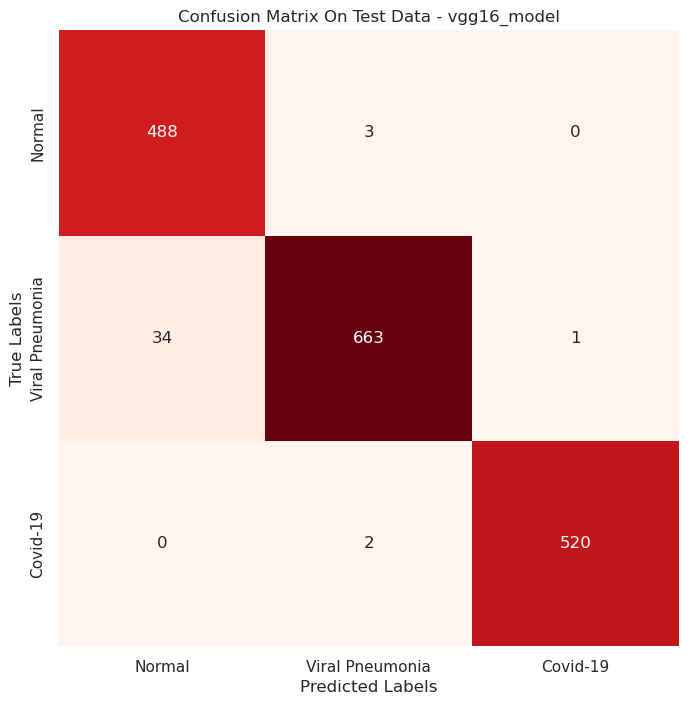

                 precision    recall  f1-score   support

         Normal      0.935     0.994     0.963       491
Viral Pneumonia      0.993     0.950     0.971       698
       Covid-19      0.998     0.996     0.997       522

       accuracy                          0.977      1711
      macro avg      0.975     0.980     0.977      1711
   weighted avg      0.978     0.977     0.977      1711

54/54 [==============================] - 7s 137ms/step


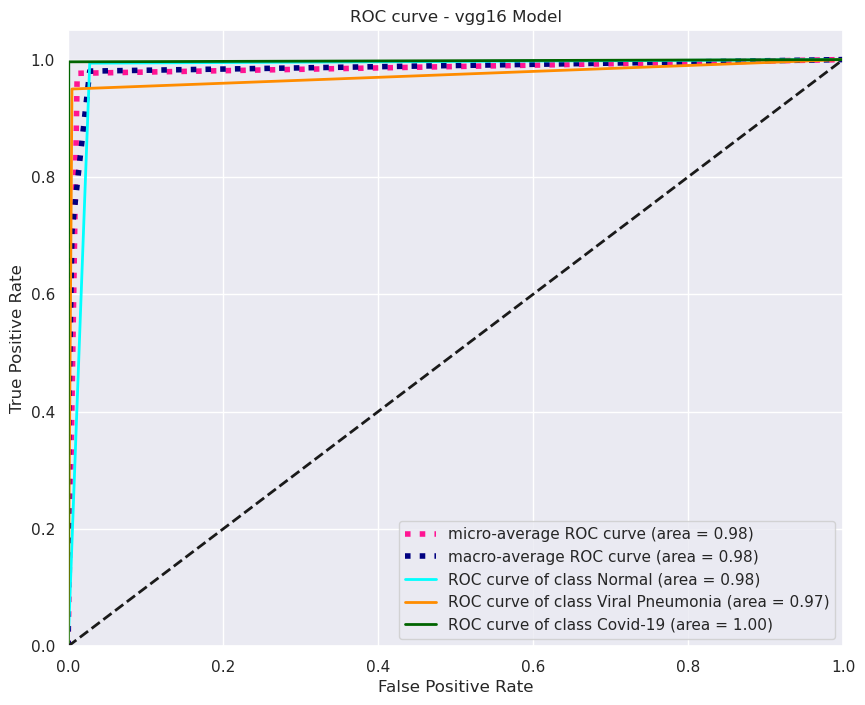

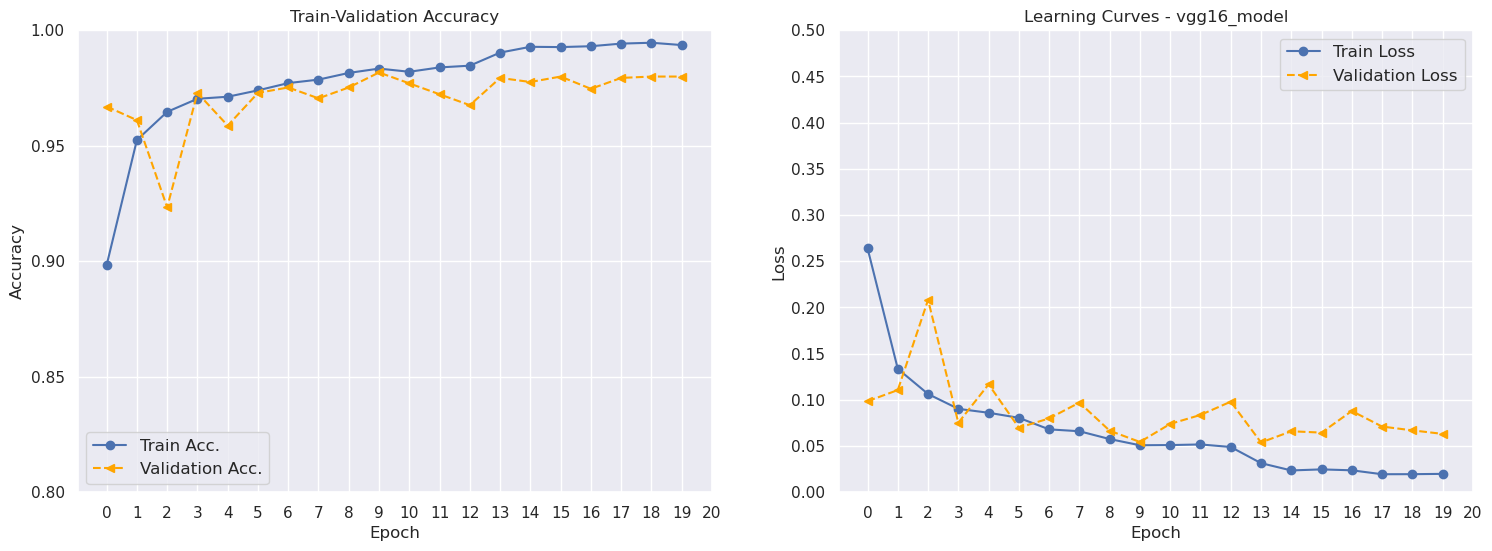

densenet121 is Running
Jumlah Layer yang dituning : 107
Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 zero_padding2d (ZeroPadding2D)  (None, 230, 230, 3)  0          ['input_2[0][0]']                
                                                                                                  
 conv1/conv (Conv2D)            (None, 112, 112, 64  9408        ['zero_padding2d[0][0]']         
                                )                                                                 
                                    

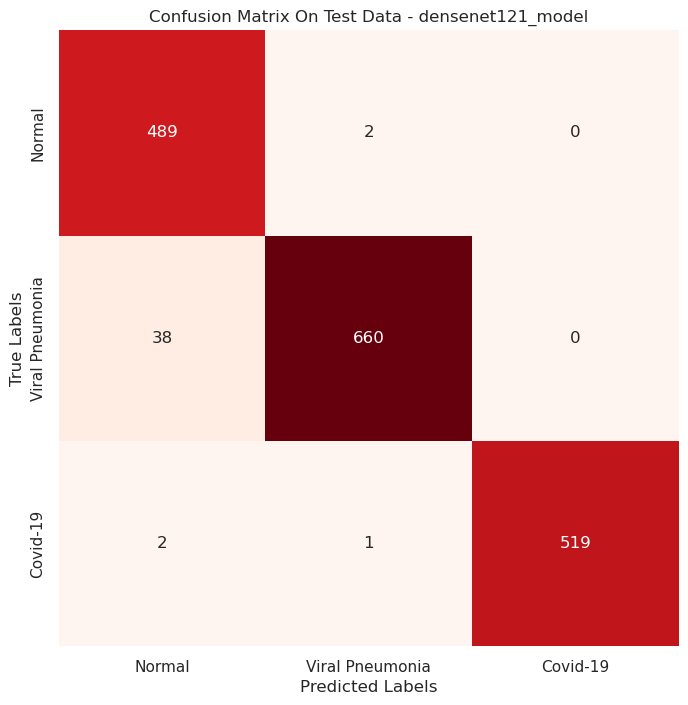

                 precision    recall  f1-score   support

         Normal      0.924     0.996     0.959       491
Viral Pneumonia      0.995     0.946     0.970       698
       Covid-19      1.000     0.994     0.997       522

       accuracy                          0.975      1711
      macro avg      0.973     0.979     0.975      1711
   weighted avg      0.976     0.975     0.975      1711

54/54 [==============================] - 8s 148ms/step


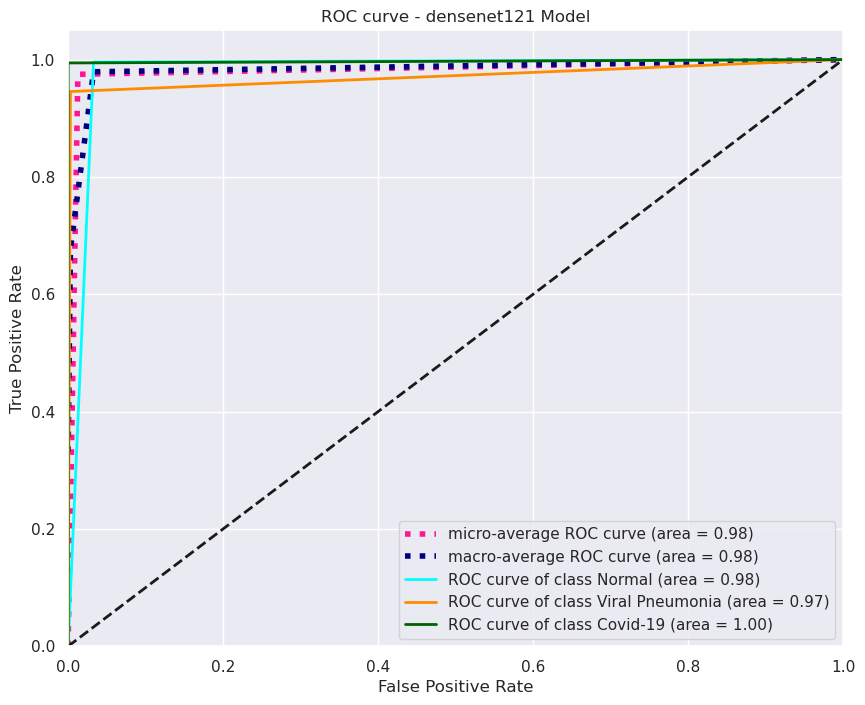

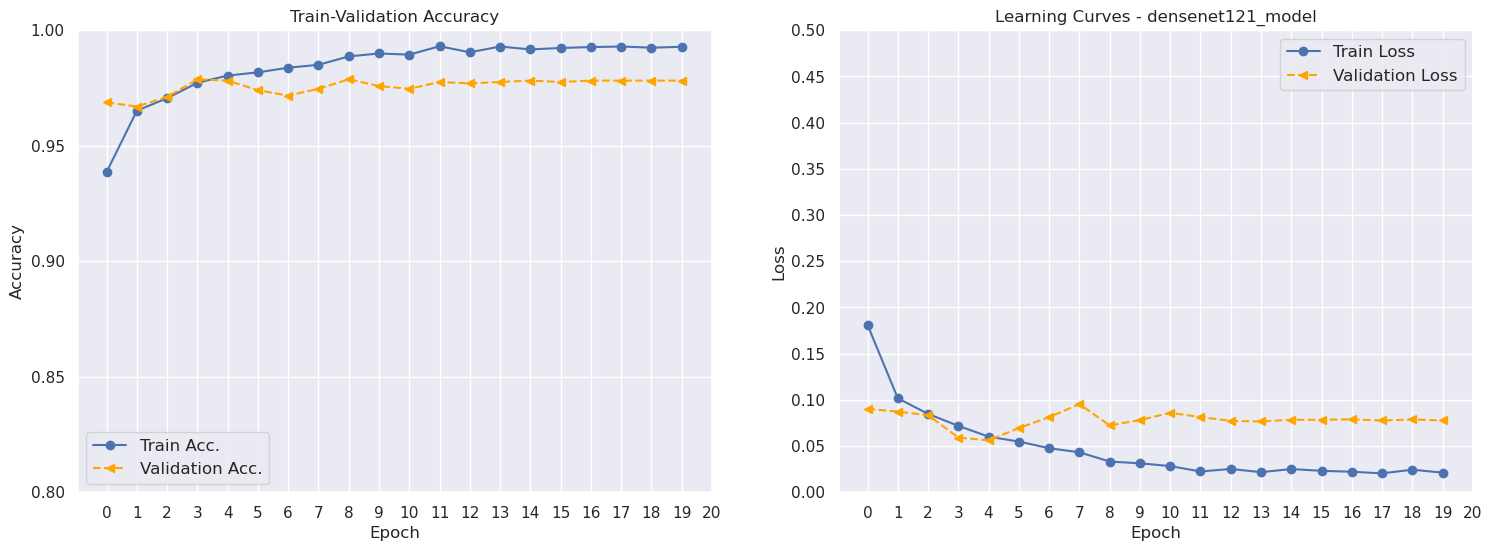

inceptionv3 is Running
Jumlah Layer yang dituning : 78
Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 111, 111, 32  864         ['input_3[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 111, 111, 32  96         ['conv2d[0][0]']                 
 alization)                     )    

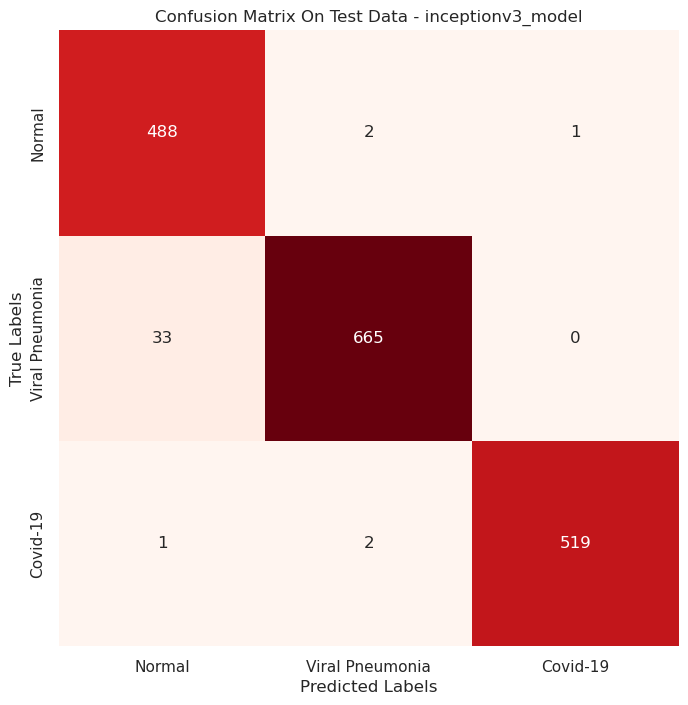

                 precision    recall  f1-score   support

         Normal      0.935     0.994     0.963       491
Viral Pneumonia      0.994     0.953     0.973       698
       Covid-19      0.998     0.994     0.996       522

       accuracy                          0.977      1711
      macro avg      0.976     0.980     0.978      1711
   weighted avg      0.978     0.977     0.977      1711

54/54 [==============================] - 7s 130ms/step


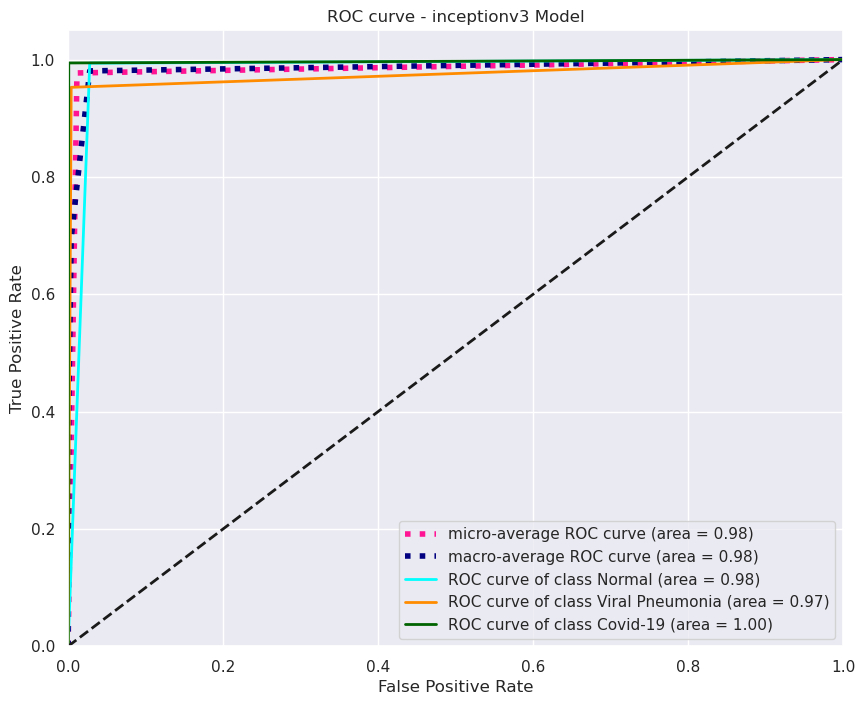

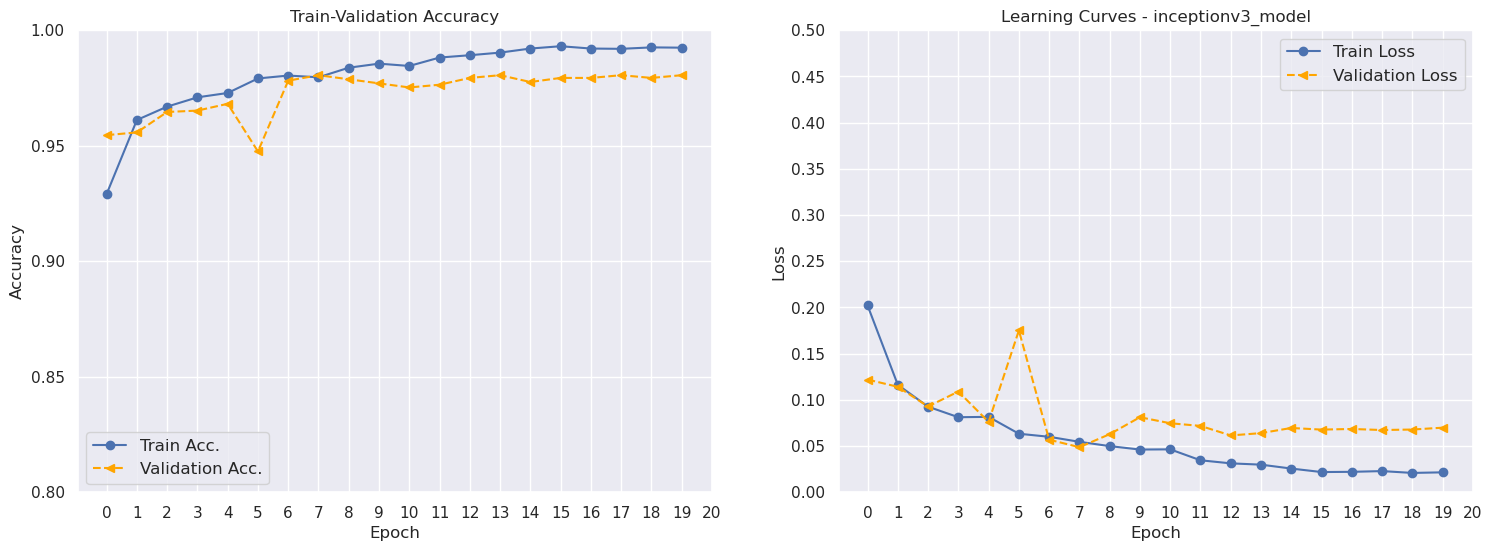

xception is Running
Jumlah Layer yang dituning : 33
Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 block1_conv1 (Conv2D)          (None, 111, 111, 32  864         ['input_4[0][0]']                
                                )                                                                 
                                                                                                  
 block1_conv1_bn (BatchNormaliz  (None, 111, 111, 32  128        ['block1_conv1[0][0]']           
 ation)                         )       

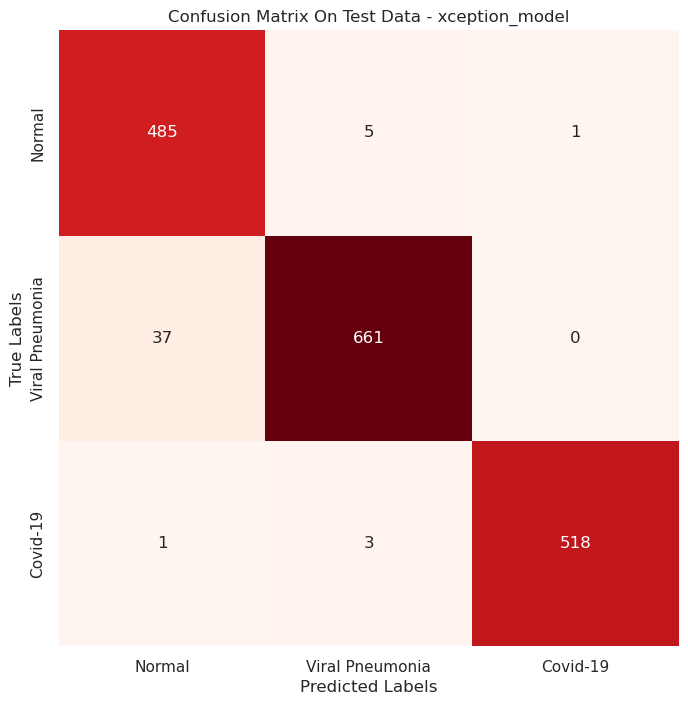

                 precision    recall  f1-score   support

         Normal      0.927     0.988     0.957       491
Viral Pneumonia      0.988     0.947     0.967       698
       Covid-19      0.998     0.992     0.995       522

       accuracy                          0.973      1711
      macro avg      0.971     0.976     0.973      1711
   weighted avg      0.974     0.973     0.973      1711

54/54 [==============================] - 8s 142ms/step


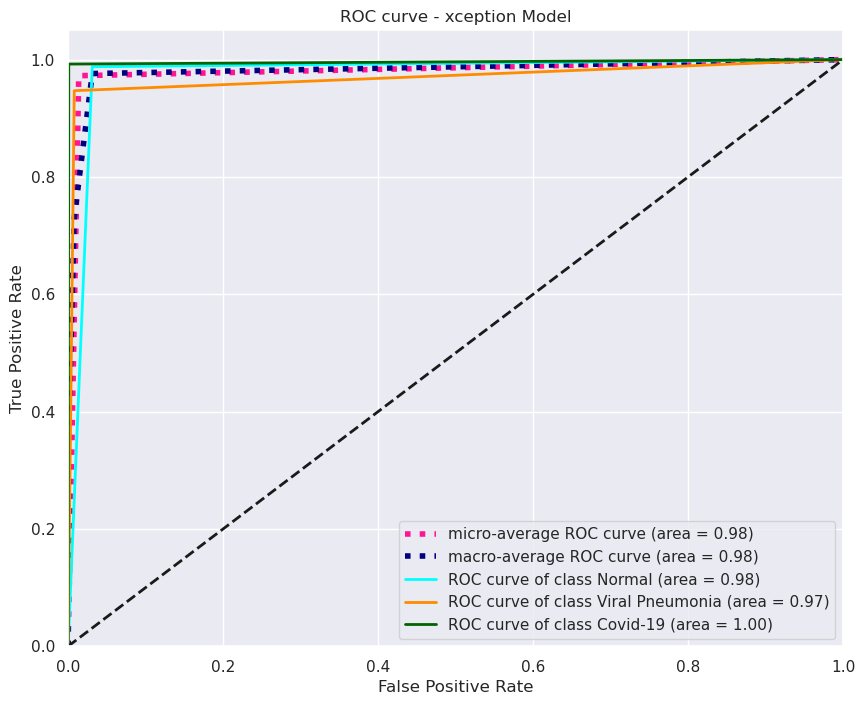

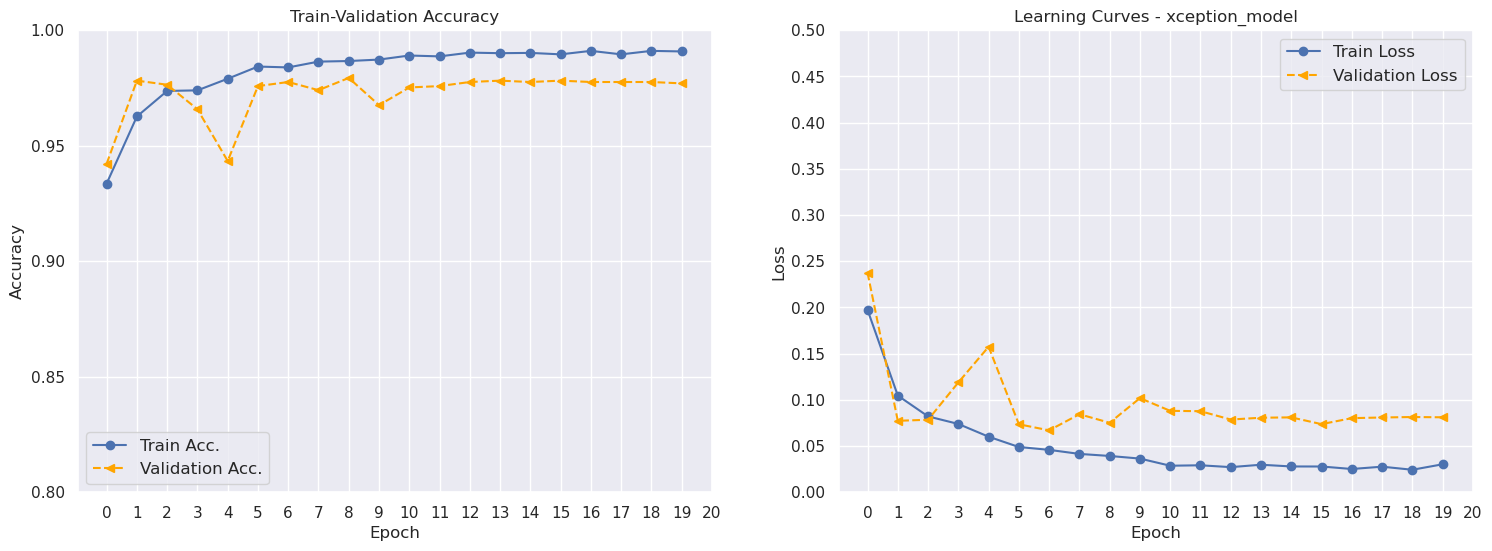

inceptresnetv2 is Running
Jumlah Layer yang dituning : 195
Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_5 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_98 (Conv2D)             (None, 111, 111, 32  864         ['input_5[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization_98 (BatchN  (None, 111, 111, 32  96         ['conv2d_98[0][0]']              
 ormalization)                  )

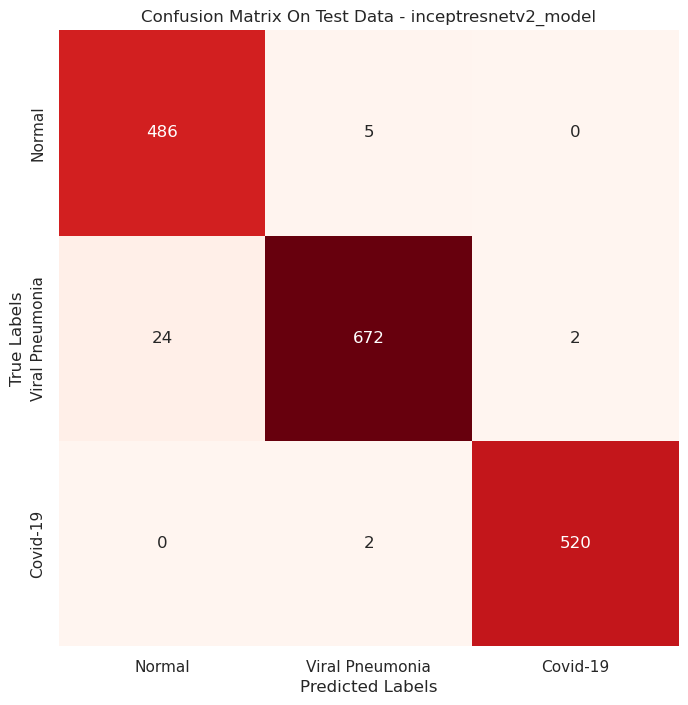

                 precision    recall  f1-score   support

         Normal      0.953     0.990     0.971       491
Viral Pneumonia      0.990     0.963     0.976       698
       Covid-19      0.996     0.996     0.996       522

       accuracy                          0.981      1711
      macro avg      0.980     0.983     0.981      1711
   weighted avg      0.981     0.981     0.981      1711

54/54 [==============================] - 8s 145ms/step


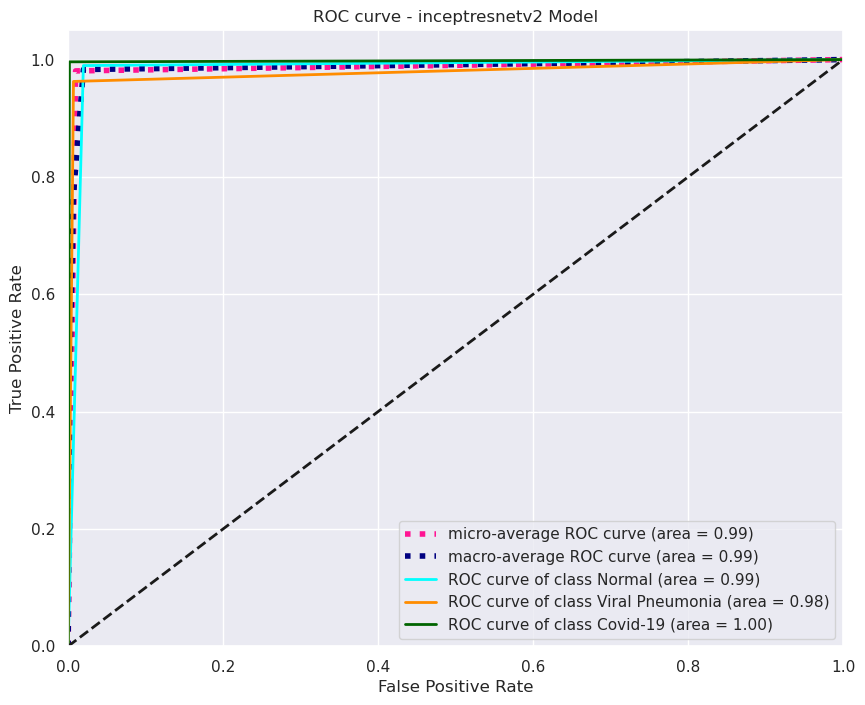

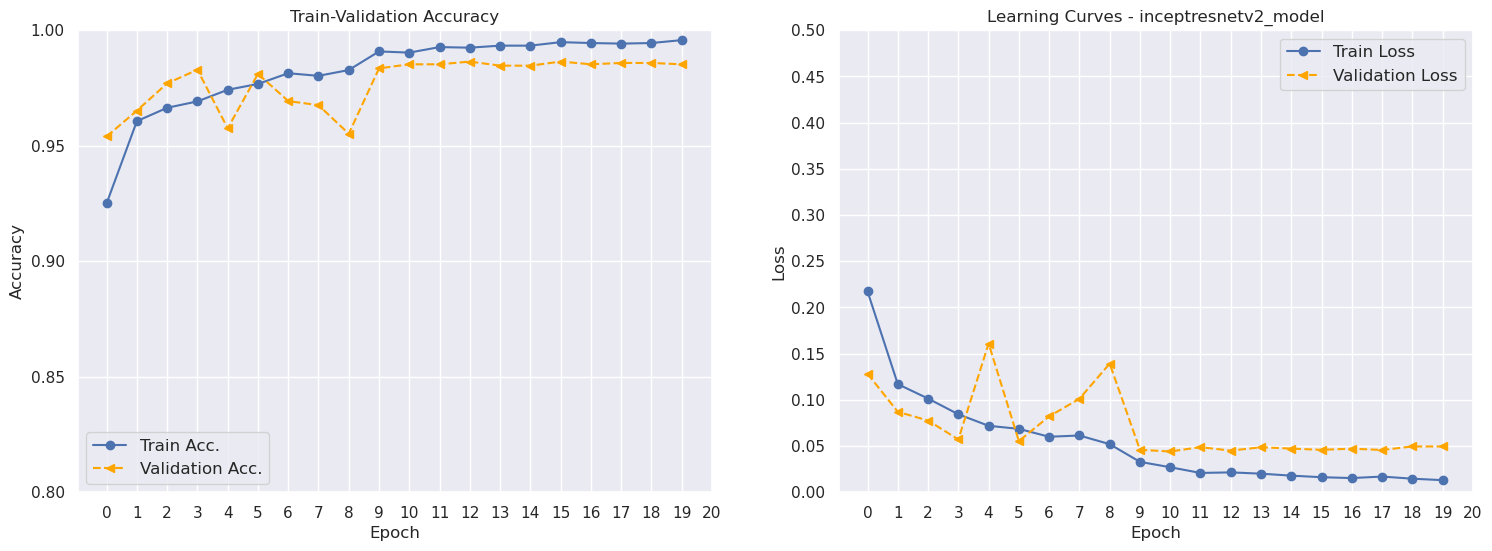

In [15]:
models_name =list(num_trainable_layers.keys())
for i, model in enumerate(models):
    print(models_name[i], "is Running")
    
    print("Jumlah Layer yang dituning :", num_trainable_layers[models_name[i]])
    
    # set the trainable layers
    for layer in model.layers:
        layer.trainable = False
    if num_trainable_layers[models_name[i]] > 0:
        for layer in model.layers[-num_trainable_layers[models_name[i]]:]:
            layer.trainable = True
    else:
        for layer in model.layers:
            layer.trainable = True
    # add a global spatial average pooling layer
    x = model.output
    x = GlobalAveragePooling2D()(x)
    x =tf.keras.layers.Dense(1024, activation='relu')(x)
    x =tf.keras.layers.Dense(1024, activation='relu')(x)
  
    # add an output layer
    predictions = Dense(3, activation='softmax')(x)
    model = tf.keras.models.Model(inputs=model.input, outputs=predictions)
    print(model.summary())
    model.compile(loss='categorical_crossentropy',
              optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
              metrics=['categorical_accuracy'])
    
    dir_todrop="/kaggle/working/{}model_weights.h5".format(models_name[i])
    !rm -r {dir_todrop}
    epochs = 20
    num_samples = train_generator.samples
    early_stopping = tf.keras.callbacks.EarlyStopping(monitor = 'loss', patience = 5, verbose = 1)
    reduce_lr =  tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', patience=3, factor=0.2, verbose=2)
    mcp = tf.keras.callbacks.ModelCheckpoint(filepath = f'{models_name[i]}model_weights.h5', monitor = 'val_categorical_accuracy', 
                          save_best_only = True, verbose = 1)
    # train the model
    start_time = time.time()
    model_history = model.fit_generator(train_generator,
                                    steps_per_epoch=num_samples //batch_size ,
                                    epochs=epochs,
                                    validation_data=validation_generator,
                                    validation_steps = validation_generator.samples // batch_size,
                                    callbacks=[early_stopping, reduce_lr, mcp])
    
    evaluateModel(model,test_generator,f'{models_name[i]}_model')
    model.save(f"{models_name[i]}_finetuned.h5")               
    testY = test_generator.classes
    class_to_label_map = {0 : 'Normal', 1 : 'Viral Pneumonial', 2 : 'Covid-19'}
    predY = model.predict(test_generator)
    y_pred= np.argmax(predY, axis=1)
    # Membuat confusion matrix
    matrix = confusion_matrix(testY, y_pred)
    # Mengonversi matrix ke dataframe pandas
    df_matrix = pd.DataFrame(matrix)
    report = classification_report(testY, y_pred, output_dict=True)
    report = pd.DataFrame(report).transpose()
    with pd.ExcelWriter(f'hasil_evaluasi {models_name[i]}.xlsx') as writer:
        # Menyimpan classification report ke dalam sheet 'Classification Report'
        report.to_excel(writer, sheet_name=f'Report {models_name[i]}', index=True)
        # Menyimpan confusion matrix ke dalam sheet 'Confusion Matrix'
        df_matrix.to_excel(writer, sheet_name=f'CMatrix {models_name[i]}')
    plot_roc_curve(testY, y_pred, f'{models_name[i]}')
    plot_learning_curves(model_history,f'{models_name[i]}_model')


In [20]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import load_model
from sklearn.metrics import roc_curve, auc

# Load the models
model_names = ['vgg16_finetuned', 'densenet121_finetuned', 'inceptionv3_finetuned', 
               'xception_finetuned', 'inceptresnetv2_finetuned']
models_name = ['VGG16', 'DenseNet121', 'InceptionV3', 
               'Xception', 'InceptionResnetV2']
models = {}

for model_name in model_names:
    model = load_model(f'{model_name}.h5')
    models[model_name] = model

In [21]:
y_test=test_generator.classes
n_classes = len(np.unique(y_test))
y_test = label_binarize(y_test, classes=np.arange(n_classes))
tmp_fpr={}
tmp_tpr={}
tmp_auc={}

# Perform predictions
predictions = {}
for model_name, model in models.items():
    predictions[model_name] = model.predict_generator(test_generator)
    fpr = dict()
    tpr = dict()
    roc_auc = dict()

    # Compute micro-average ROC curve and ROC area
    fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), predictions[model_name].ravel())
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])
    tmp_fpr[model_name]=fpr["micro"]
    tmp_tpr[model_name]=tpr["micro"]
    tmp_auc[model_name]=auc(fpr["micro"], tpr["micro"])
    

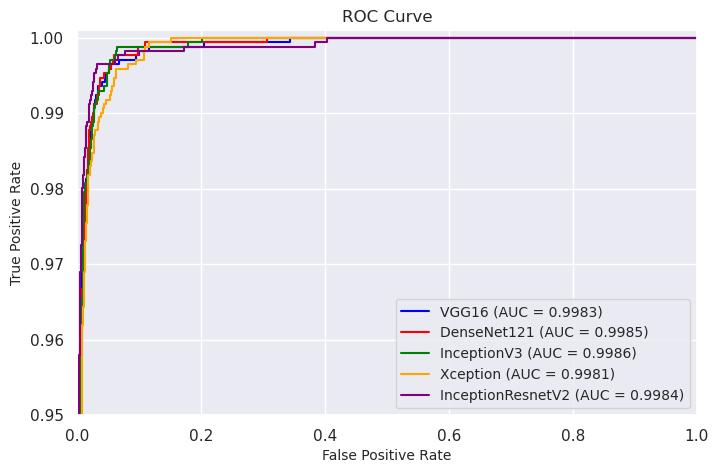

In [27]:
from matplotlib.ticker import FormatStrFormatter
# Set color cycle for lines
from itertools import cycle
colors = cycle(['blue', 'red', 'green', 'orange', 'purple'])

plt.figure(figsize=(8,5))

# Plot ROC curves for each model
for model_name, color, name in zip(model_names, colors, models_name ):
    plt.plot(
        tmp_fpr[model_name],
        tmp_tpr[model_name],
        color=color,
        linestyle='-',
        lw=1.5,
        label=f'{name} (AUC = {tmp_auc[model_name]:.4f})'
    )

# Plot settings
# plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.95, 1.001])

plt.xlabel('False Positive Rate', fontsize=10)
plt.ylabel('True Positive Rate', fontsize=10)
plt.title('ROC Curve')
plt.legend(loc='lower right',fontsize=10)
plt.savefig(f"ROC curve - Comparison Model Dataset2.png")
plt.show()